In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Training data loaded
Validation data loaded


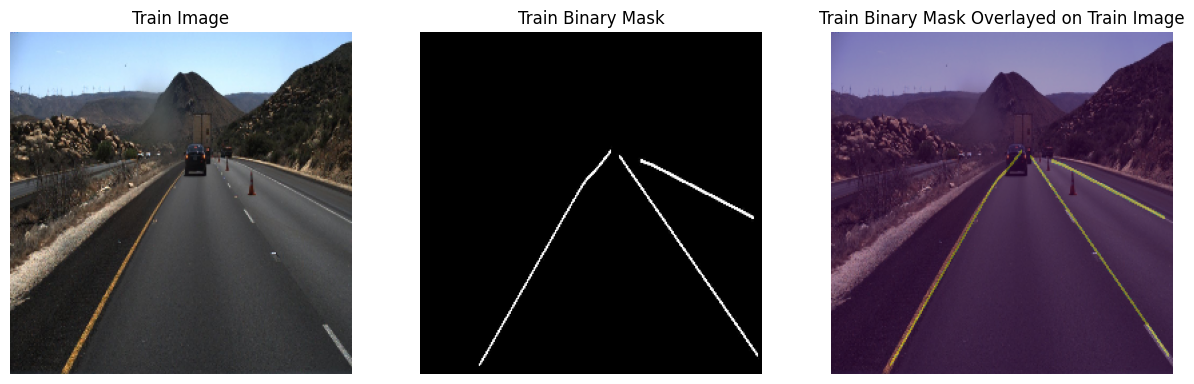

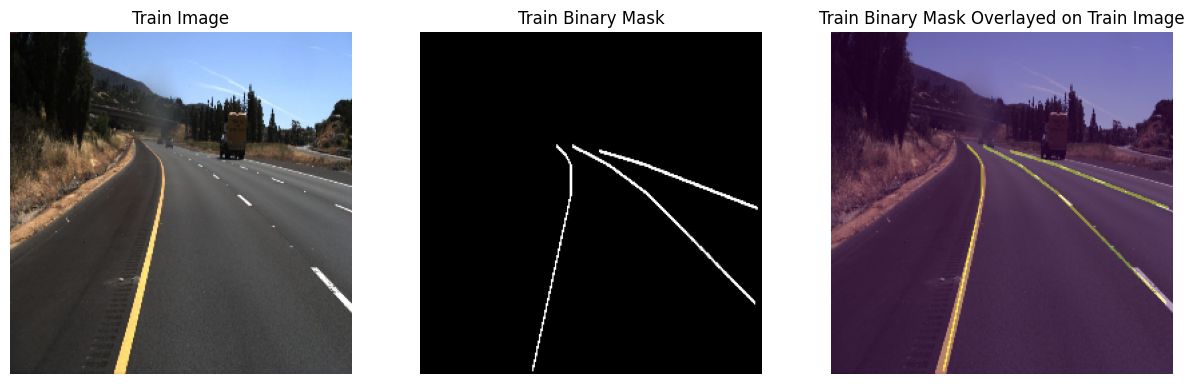

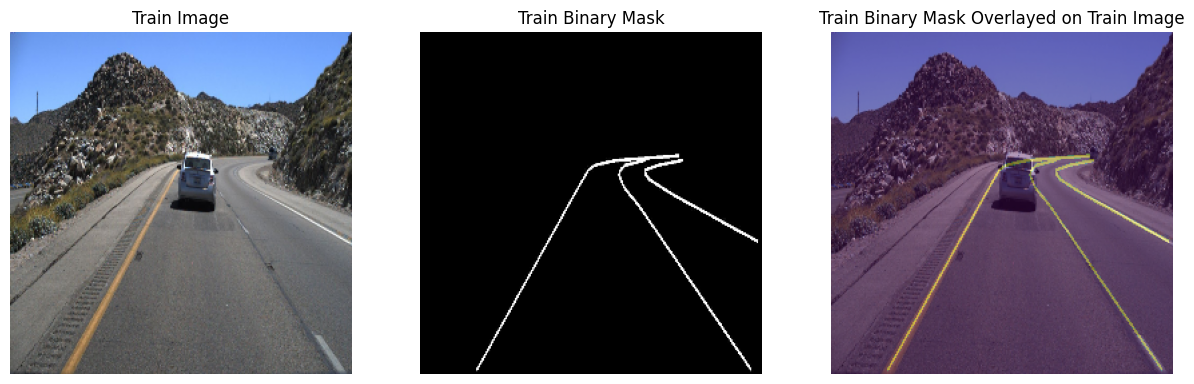

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

train_images = np.load('/content/drive/MyDrive/Honours project/Prepared Data/X_train.npy')
train_binary_masks = np.load('/content/drive/MyDrive/Honours project/Prepared Data/y_train.npy')
print("Training data loaded")

val_images = np.load('/content/drive/MyDrive/Honours project/Prepared Data/X_test.npy')
val_binary_masks = np.load('/content/drive/MyDrive/Honours project/Prepared Data/y_test.npy')
print("Validation data loaded")

for index in [0, 2, 3]:
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.imshow(train_images[index])
    plt.title('Train Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(train_binary_masks[index], cmap='gray')
    plt.title('Train Binary Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(train_binary_masks[index])
    plt.imshow(train_images[index], alpha=0.6)
    plt.title('Train Binary Mask Overlayed on Train Image')
    plt.axis('off')

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def multi_resolution_block(x_high, x_low, filters_high, filters_low):
    high_path = residual_block(x_high, filters_high)

    low_path = residual_block(x_low, filters_low)
    low_path = tf.keras.layers.Conv2D(filters_high, 1, strides=1)(low_path)
    low_path = tf.keras.layers.UpSampling2D(size=(2, 2))(low_path)

    fused = tf.keras.layers.add([high_path, low_path])
    return fused

def hrnet_block(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    x_high = tf.keras.layers.Conv2D(64, 3, padding='same')(inputs)

    x_low = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_high)
    for _ in range(4):
        x_high = multi_resolution_block(x_high, x_low, 64, 128)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x_high)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='HRNet_Like_Model')
    return model

model = hrnet_block()

plot_model(model, to_file="hrnet_like_model.png", show_shapes=True, show_layer_names=True)

model.summary()


Model: "HRNet_Like_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 128, 128, 64)   │              0 │ conv2d_78[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_81 (Conv2D)        │ (None, 128, 128, 128)  │         73,728 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_62    │ (None, 128, 128, 128)  │            512 │ conv2d_81[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 256, 256, 64)   │         36,864 │ conv2d_78[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_50             │ (None, 128, 128, 128)  │              0 │ batch_normalization_6… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_60    │ (None, 256, 256, 64)   │            256 │ conv2d_79[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_82 (Conv2D)        │ (None, 128, 128, 128)  │        147,456 │ activation_50[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_83 (Conv2D)        │ (None, 128, 128, 128)  │          8,192 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_48             │ (None, 256, 256, 64)   │              0 │ batch_normalization_6… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_63    │ (None, 128, 128, 128)  │            512 │ conv2d_82[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_64    │ (None, 128, 128, 128)  │            512 │ conv2d_83[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 256, 256, 64)   │         36,864 │ activation_48[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_37 (Add)              │ (None, 128, 128, 128)  │              0 │ batch_normalization_6… │
│                           │                        │                │ batch_normalization_6… │
├──────────────────────

 Total params: 1,255,489 (4.79 MB)

 Trainable params: 1,251,393 (4.77 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model = hrnet_block(input_shape=(256, 256, 3))
print("Enhanced Simplified HRNet model built.")

checkpoint_path = '/content/drive/MyDrive/enhanced_hrnet_model.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                    save_weights_only=False,
                                    save_best_only=False,
                                    save_freq='epoch',
                                    verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-6,
                              verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

print("Model compiled.")

history = model.fit(train_images,
                    train_binary_masks,
                    epochs=50,
                    batch_size=4,
                    validation_data=(val_images, val_binary_masks),
                    callbacks=[model_checkpoint, reduce_lr, early_stopping])

print("Training complete. Model saved at every epoch.")


Enhanced Simplified HRNet model built.
Model compiled.
Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8184 - loss: 0.5310 - precision_1: 0.0546 - recall_1: 0.2196
Epoch 1: saving model to /content/drive/MyDrive/enhanced_hrnet_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 297ms/step - accuracy: 0.8200 - loss: 0.5261 - precision_1: 0.0550 - recall_1: 0.2181 - val_accuracy: 0.9691 - val_loss: 0.2142 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9671 - loss: 0.0652 - precision_1: 0.6948 - recall_1: 0.1213
Epoch 2: saving model to /content/drive/MyDrive/enhanced_hrnet_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 287ms/step - accuracy: 0.9671 - loss: 0.0652 - precision_1: 0.6954 - recall_1: 0.1214 - val_accuracy: 0.9691 - val_loss: 0.1102 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step -

In [9]:
model.save('/content/drive/MyDrive/enhanced_hrnet_model.h5')
print("Trained model saved")

Trained model saved
